In [1]:
# Required modules
import os
import sys
sys.path.append('../OceanVIM/notebooks/')
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pygmt

import VIM_tools as vt
import pyshtools
from scipy.interpolate import RectSphereBivariateSpline


%matplotlib inline
%load_ext autoreload
%autoreload 2

HM = np.loadtxt('grids/W19_l90.xyz')

lons = HM[:,0].reshape(720,1440)
lats = HM[:,1].reshape(720,1440)
sus = HM[:,2].reshape(720,1440)

sus = np.hstack((sus[:,720:],sus[:,:720]))
lons = np.hstack((lons[:,720:],lons[:,:720]+360))



/opt/anaconda3/envs/pygmt/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


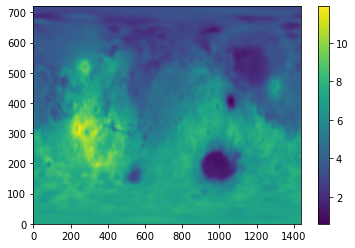

In [104]:
#sus_test = np.zeros_like(sus)
#sus_test[350:480,100:140] = 5.
#sus_test = np.random.random(sus.shape)*10.

sus_test = np.copy(sus)*0.0001

plt.pcolormesh(sus_test)
plt.colorbar()


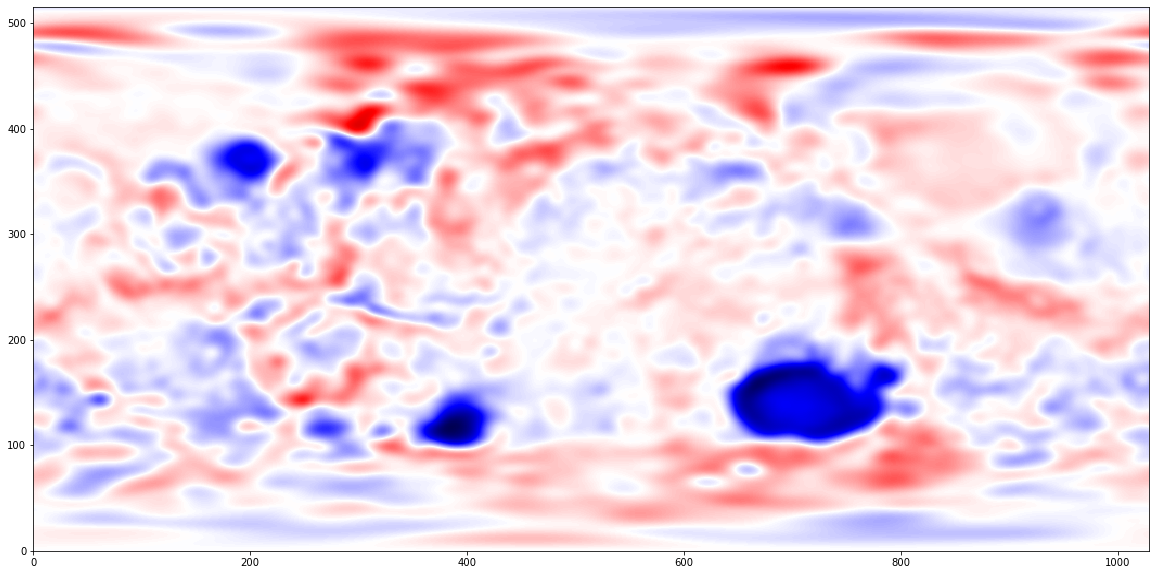

In [121]:
(HM_IVIM_Mr, 
 HM_IVIM_Mtheta, 
 HM_IVIM_Mphi) = vt.vis2magnetisation(np.flipud(sus_test))


vt.write_vh0_input(lons[0,:].flatten(),90-lats[:,0].flatten(),HM_IVIM_Mr,HM_IVIM_Mtheta,HM_IVIM_Mphi,filename='total_py.in')

os.system('vh0 < total_py.in')

# The skip is to remove lines for harmonic degrees 14 and lower 
coeffs, lmaxout = pyshtools.shio.shread('./glm.out')#,skip=104)


r0 = 3389500.
alt = 150000.

result = pyshtools.SHMagCoeffs.from_array(coeffs, r0=r0)

resultg = result.expand(a=r0+alt, sampling=2, extend=True)

plt.figure(figsize=(20,10))
plt.pcolormesh(-resultg.rad.to_array(),vmin=-100,vmax=100,cmap=plt.cm.seismic)



/opt/anaconda3/envs/pygmt/lib/python3.8/site-packages/pyshtools/shclasses/shmagcoeffs.py:2178: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/envs/pygmt/lib/python3.8/site-packages/pyshtools/shclasses/shmagcoeffs.py:2178: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Spherical harmonic degree', ylabel='Power, nT$^2$'>)

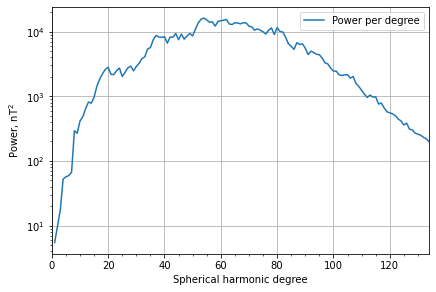

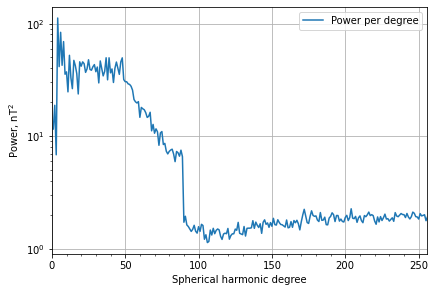

In [10]:
# Load coefficients for Mars magnetic model of Langlais++ 2018
clm_lang, lmax = pyshtools.shio.shread('./shc/Langlais++_Mars.cof')

clmm = pyshtools.SHMagCoeffs.from_array(clm_lang, r0=3389500.)

clmm.plot_spectrum()
result.plot_spectrum()

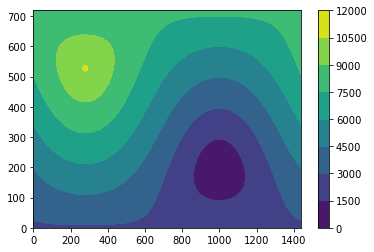

10669.445
10649.999095669398


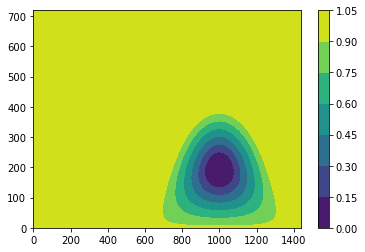

In [126]:
HellasDistance = xr.open_dataarray('DistanceToHellasCentre.nc')

plt.contourf(HellasDistance.data)
plt.colorbar()
plt.show()

print(HellasDistance.data.max())
print(3390*np.pi)

inner_limit = 500.
outer_limit = 3000.

ramping = HellasDistance.data.copy()
ramping[ramping<inner_limit] = inner_limit
ramping[ramping>outer_limit] = outer_limit
ramping = (ramping-inner_limit)/(outer_limit-inner_limit)

plt.contourf(ramping)
plt.colorbar()
plt.show()


0.0
1.0


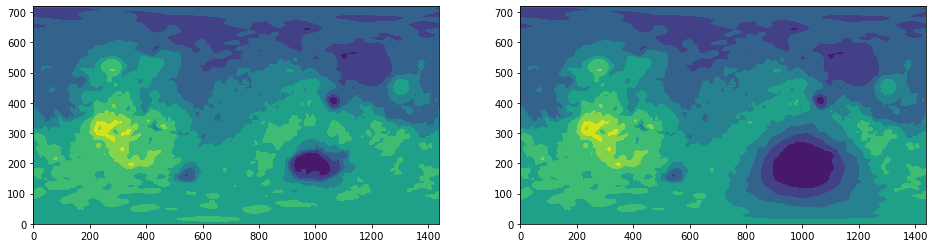

In [127]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.contourf(sus_test)
plt.subplot(122)
plt.contourf(sus_test*ramping)
print(np.min(ramping))
print(np.max(ramping))

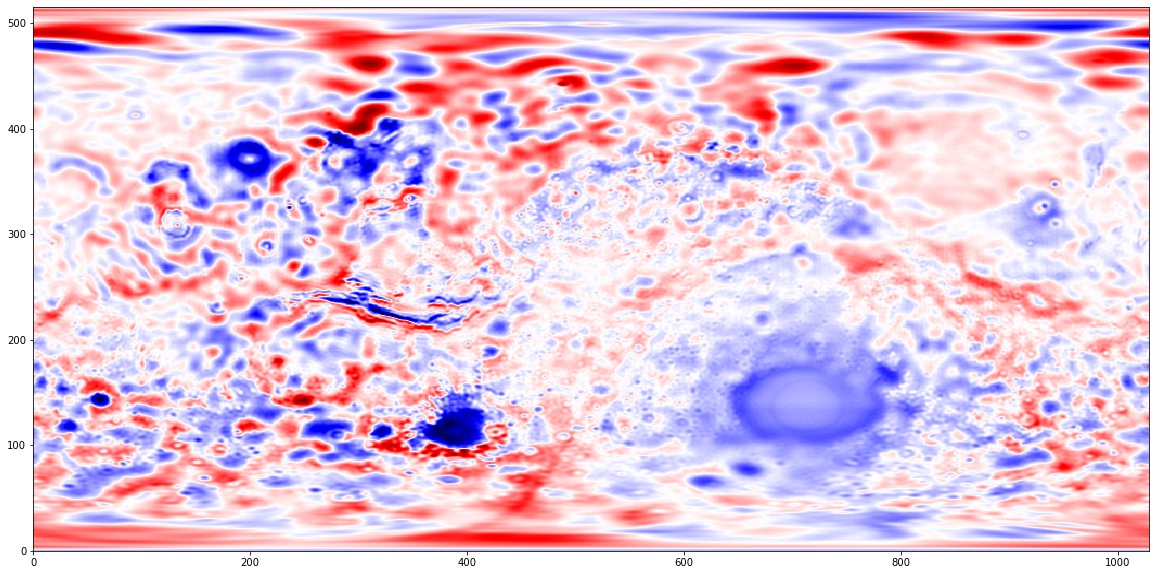

In [128]:
(HM_IVIM_Mr, 
 HM_IVIM_Mtheta, 
 HM_IVIM_Mphi) = vt.vis2magnetisation(np.flipud(sus_test*ramping))


vt.write_vh0_input(lons[0,:].flatten(),90-lats[:,0].flatten(),HM_IVIM_Mr,HM_IVIM_Mtheta,HM_IVIM_Mphi,filename='total_py.in')

os.system('vh0 < total_py.in')

# The skip is to remove lines for harmonic degrees 14 and lower 
coeffs, lmaxout = pyshtools.shio.shread('./glm.out')#,skip=104)
#coeffs, lmaxout = pyshtools.shio.shread('./glm.out',skip=104)


r0 = 3389500.
alt = 10000.

result = pyshtools.SHMagCoeffs.from_array(coeffs, r0=r0)

resultg = result.expand(a=r0+alt, sampling=2, extend=True)

plt.figure(figsize=(20,10))
plt.pcolormesh(-resultg.rad.to_array(),vmin=-200,vmax=200,cmap=plt.cm.seismic)

